# Initialization

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [ ]:
from clustering.utils import *

# Load Data

In [ ]:
df_rvalue = pd.read_csv('data/inferred_rvalue.csv')
df_rvalue.date = pd.to_datetime(df_rvalue.date, format='%Y-%m-%d')
df_rvalue.head()

,date,R_t
0,2020-07-31,1.633441
1,2020-08-01,1.636637
2,2020-08-02,1.639839
3,2020-08-03,1.643047
4,2020-08-04,1.646260


In [ ]:
factor_cols = get_factor_cols()

In [ ]:
start_train = '2020-08-01'
df, cluster_input_cols, _, _, _, _ = get_cluster_data(n_cluster=2, method='kmeans', cov_type='full', cluster_input_data='fa_data', start_train=start_train, end_train='2020-12-01', start='2020-07-21')
df.head()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,gender,postnr,region,Q1_1_feel_exposed,Q1_2_covid_is_threat,...,Q16_Unsure_of_party_choice,Q16_Venstre,Vaccination_Status,Willingness_Vaccination,Q4_1_nr_contact_nonhouse_family,Q4_2_nr_contact_colleagues,Q4_3_nr_contact_friends,Q4_4_nr_contact_strangers,Q7_last_week_symptom,group
0,1.000000,0.819706,0.916667,0.250000,0.555556,1,4654,Zealand,3.0,7.0,...,0,0,NaN,NaN,0,0,2,2,0,0
1,0.875000,0.666667,0.291667,0.416667,0.611111,0,4700,Zealand,6.0,6.0,...,0,0,NaN,NaN,4,1,4,15,0,1
2,0.708333,0.083333,0.041667,0.666667,0.111111,0,4000,Zealand,2.0,5.0,...,1,0,NaN,NaN,4,0,0,1,0,1
3,1.000000,0.972222,0.750000,0.833333,0.611111,0,8543,Central,4.0,4.0,...,0,0,NaN,NaN,0,0,0,0,1,0
4,0.958333,0.916667,0.958333,1.000000,0.500000,1,3760,Capital,2.0,1.0,...,0,0,NaN,NaN,0,0,1,0,0,0


In [ ]:
group_nr = 1
df_group = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = df_group[df_group['date']==row['date']]['gender'].sum()
  return row['gender']/sum
df_group['percentage'] = df_group.apply(lambda x: normalize(x), axis=1)
df_group.drop(columns='gender',inplace=True)
df_group = df_group[df_group['group'] == group_nr].reset_index(drop=True)
df_group = df_group.groupby('date').mean().rolling(7).mean().reset_index()
df_group = df_group.dropna().reset_index(drop=True)
df_group = df_group[df_group.date >= start_train]
df_group.head()

,date,group,percentage
5,2020-08-01,1.0,0.423189
6,2020-08-02,1.0,0.416922
7,2020-08-03,1.0,0.417142
8,2020-08-04,1.0,0.424950
9,2020-08-05,1.0,0.426723


In [ ]:
"""
df_alternativ = pd.read_csv('data/clustering/220309_percentage_non_careful.csv')
df_alternativ.date = pd.to_datetime(df_alternativ.date, format='%Y-%m-%d')
df_group = df_alternativ
df_group = df_group.groupby('date').mean().rolling(7).mean().reset_index()
df_group = df_group[(df_group.date >= start_train) & (df_group.date < '2021-02-01')]
df_group.info()"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 64 to 247
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        184 non-null    datetime64[ns]
 1   Unnamed: 0  184 non-null    float64       
 2   percentage  184 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 5.8 KB


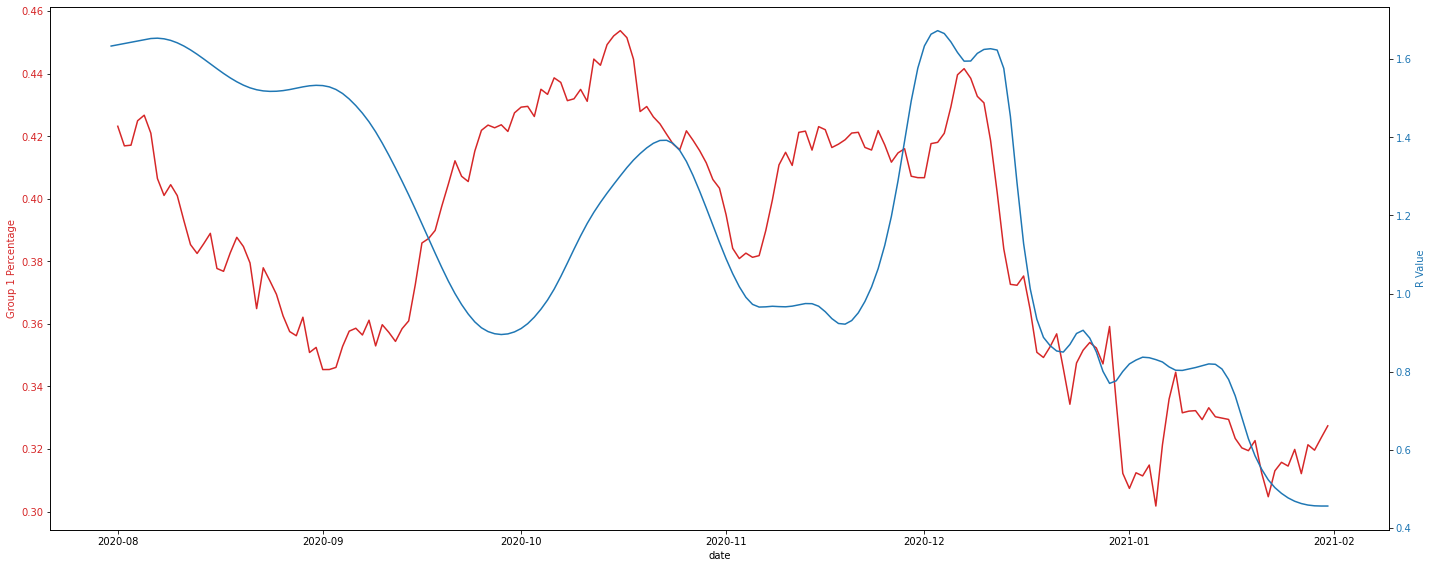

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 8))
df_group['percentage_transformed'] = np.exp(df_group['percentage'])
color = 'tab:red'
ax1.set_xlabel('date')
ax1_ylabel = 'Group ' + str(group_nr) + ' Percentage'
ax1.set_ylabel(ax1_ylabel, color=color)
ax1.plot(df_group['date'], df_group['percentage'], color=color)
#ax1.plot(df_group['date'], df_group['percentage_transformed'], color='grey')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R Value', color=color)  # we already handled the x-label with ax1
ax2.plot(df_rvalue['date'], df_rvalue['R_t'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Comparison Factor Values and R Value

In [ ]:
df_factor = df.groupby('date').mean().rolling(7).mean()[factor_cols].reset_index()
df_factor = df_factor[df_factor.date >= start_train]
df_factor

,date,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice
11,2020-08-01,0.743703,0.731844,0.788875,0.524872,0.434281
12,2020-08-02,0.746341,0.732994,0.791286,0.533191,0.435649
13,2020-08-03,0.744210,0.731432,0.791726,0.531481,0.435569
14,2020-08-04,0.746002,0.727886,0.791847,0.528625,0.439712
15,2020-08-05,0.749690,0.725442,0.793338,0.527307,0.435948
...,...,...,...,...,...,...
190,2021-01-27,0.856608,0.740694,0.799087,0.670694,0.614807
191,2021-01-28,0.851948,0.734714,0.803258,0.669949,0.619640
192,2021-01-29,0.853168,0.735961,0.803334,0.668453,0.617294
193,2021-01-30,0.848604,0.730046,0.804182,0.666618,0.614588


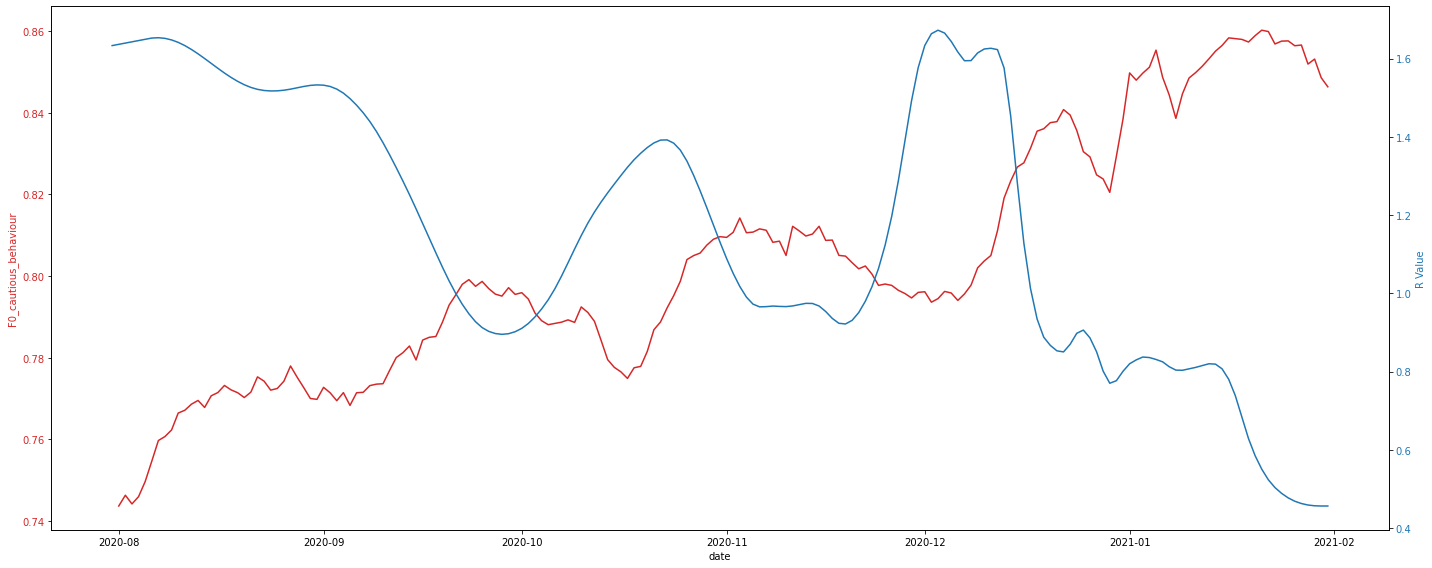

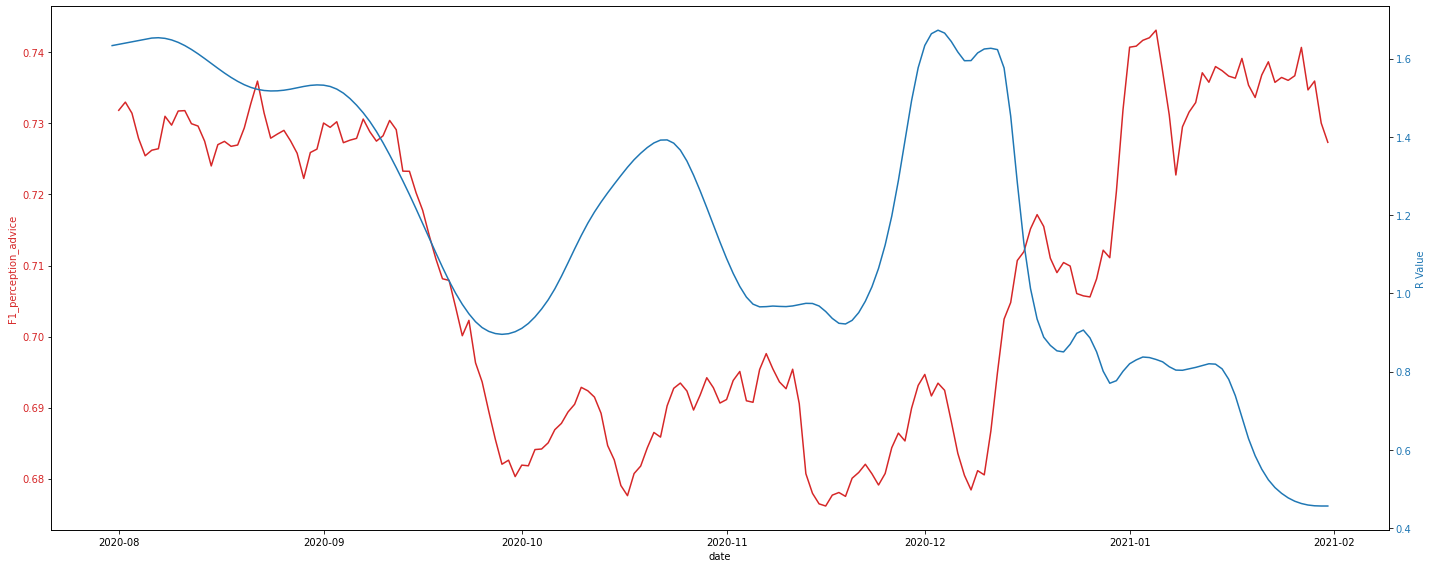

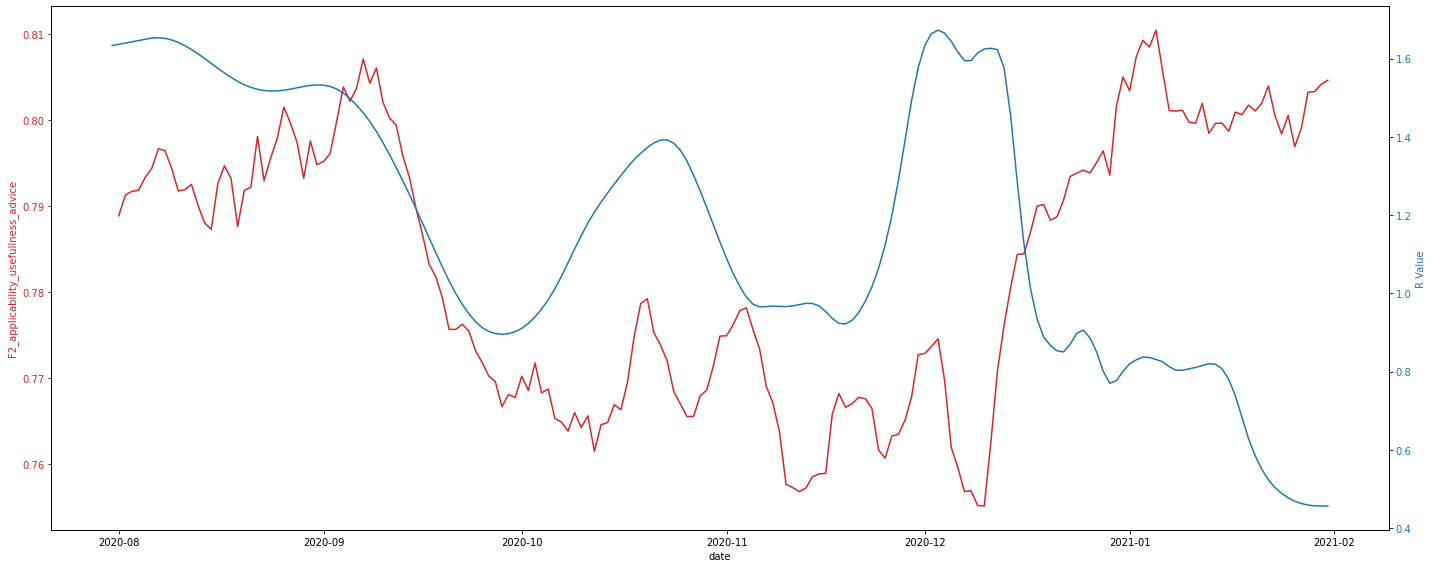

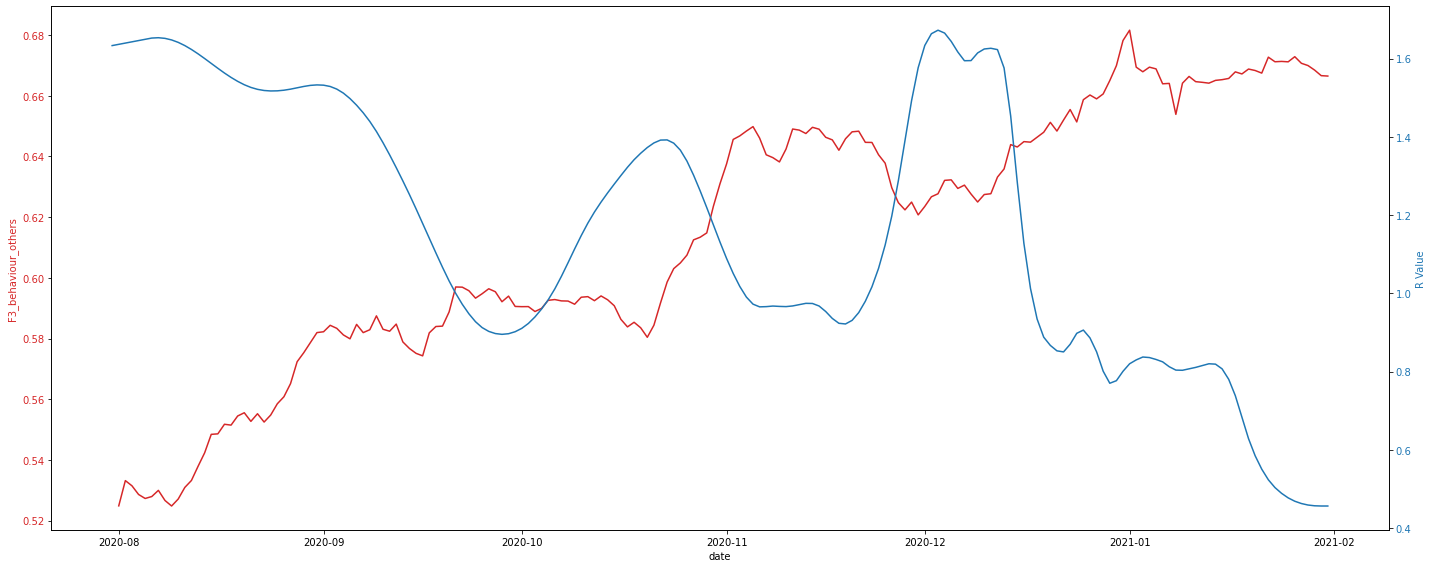

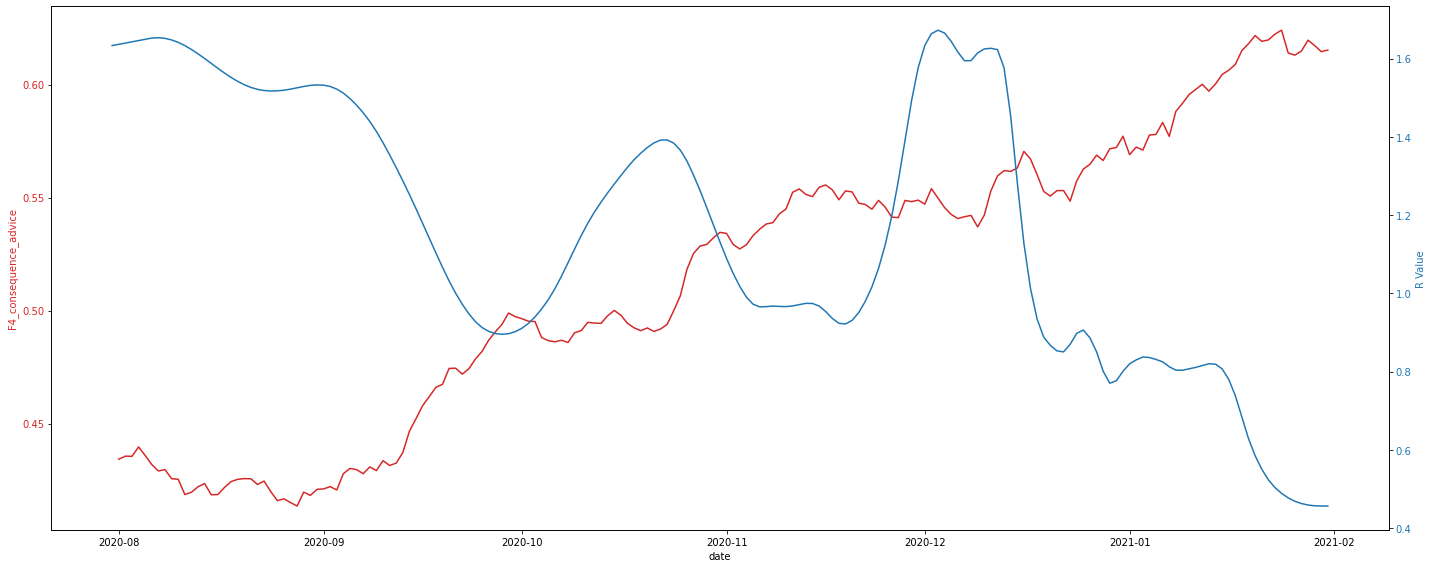

In [ ]:
for column in factor_cols:

  fig, ax1 = plt.subplots(figsize=(20, 8))
  color = 'tab:red'
  ax1.set_xlabel('date')
  ax1_ylabel = column
  ax1.set_ylabel(ax1_ylabel, color=color)
  ax1.plot(df_factor['date'], df_factor[column], color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('R Value', color=color)  # we already handled the x-label with ax1
  ax2.plot(df_rvalue['date'], df_rvalue['R_t'], color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()